In [13]:
%pylab inline
sc.version

Populating the interactive namespace from numpy and matplotlib


u'1.3.1'

In [1]:
from xmltodict import parse as parse_xml
from pyspark.sql import SQLContext, Row
from dateutil.parser import parse as parse_date
import re
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
def xml_to_rdd(file_name):
    def infer_type(input):
        int_re = re.compile('^[\-]?[0-9]+$')
        date_re = re.compile('^[0-9]{4}-[0-9]{2}-[0-9]{2}T[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{3}$')
        int_type = (int_re.match, int)
        date_type = (date_re.match, parse_date)
        default_type = (lambda x: True, lambda x: x)

        for f, c in [int_type, date_type, default_type]:
            if f(input):
                return c(input)

    def clean_xml_dict(xd):
        return {
                key[1:]: infer_type(value.strip())
                for key, value in xd.items() if key.startswith('@')
            }

    return sc.textFile(file_name)\
    .filter(lambda line: line.strip().startswith('<row'))\
    .map(lambda line: parse_xml(line))\
    .map(lambda xml_dict: xml_dict['row'])\
    .map(clean_xml_dict)

def extract_fields(row, wanted):
    return {
        k: row.get(k, None)
        for k in wanted
    }

def rdd_to_df(rdd, columns, sql_context):
    rows = rdd.map(lambda r: extract_fields(r, columns))\
    .map(lambda r: Row(**r))
    
    return sql_context.createDataFrame(rows)

data_folder = '/Users/ivoeverts/data/goto2015/se/'

In [3]:
sql_context = SQLContext(sc)

In [17]:
posts = xml_to_rdd(data_folder + 'Posts.xml')
posts.take(1)

[{u'AcceptedAnswerId': 393,
  u'AnswerCount': 4,
  u'Body': u"<p>My fianc\xe9e and I are looking for a good Caribbean cruise in October and were wondering which islands are best to see and which Cruise line to take?</p>\n\n<p>It seems like a lot of the cruises don't run in this month due to Hurricane season so I'm looking for other good options.</p>\n\n<p><strong>EDIT</strong> We'll be travelling in 2012.</p>",
  u'ClosedDate': datetime.datetime(2013, 2, 25, 23, 52, 47, 953000),
  u'CommentCount': 4,
  u'CreationDate': datetime.datetime(2011, 6, 21, 20, 19, 34, 730000),
  u'FavoriteCount': 1,
  u'Id': 1,
  u'LastActivityDate': datetime.datetime(2012, 5, 24, 14, 52, 14, 760000),
  u'LastEditDate': datetime.datetime(2011, 12, 28, 21, 36, 43, 910000),
  u'LastEditorUserId': 101,
  u'OwnerUserId': 9,
  u'PostTypeId': 1,
  u'Score': 8,
  u'Tags': u'<caribbean><cruising><vacation>',
  u'Title': u'What are some Caribbean cruises for October?',
  u'ViewCount': 309}]

In [5]:
posts_df = rdd_to_df(posts,
               ['Id', 'Score', 'ViewCount', 'FavoriteCount', 'PostTypeId',
                'AnswerCount', 'CommentCount', 'Title', 'OwnerUserId'],
               sql_context).na.fill(0)
posts_df.show()

AnswerCount CommentCount FavoriteCount Id OwnerUserId PostTypeId Score Title                ViewCount
4           4            1             1  9           1          8     What are some Car... 309      
7           4            4             2  13          1          23    How can I find a ... 773      
0           2            0             3  9           2          10    null                 0        
1           1            0             4  24          1          8     Does Singapore Ai... 209      
5           0            2             5  13          1          11    What is the easie... 287      
6           8            16            6  19          1          64    How can I visit A... 2281     
3           2            0             8  26          1          9     Best way to get f... 5205     
4           1            7             9  23          1          12    What are must-vis... 1162     
19          11           22            10 10          1          86    When travel

In [6]:
posts_df.orderBy(posts_df.CommentCount.desc()).show()

AnswerCount CommentCount FavoriteCount Id    OwnerUserId PostTypeId Score Title                ViewCount
8           42           40            24540 11743       1          151   How to intentiona... 52167    
3           30           3             23090 9824        1          14    UK tourist visa r... 2780     
0           27           0             18396 1372        2          27    null                 0        
10          26           49            3080  140         1          196   OK we're all adul... 26765    
0           26           0             3083  88          2          135   null                 0        
1           26           1             27632 13280       1          6     Is there a docume... 233      
1           24           1             26469 13173       1          1     Overstaying stude... 412      
1           23           0             35002 140         1          5     Can e-cigarettes ... 385      
5           23           2             17641 2523      

In [11]:
posts_df_pd = posts_df.sample(False, 0.01).toPandas()

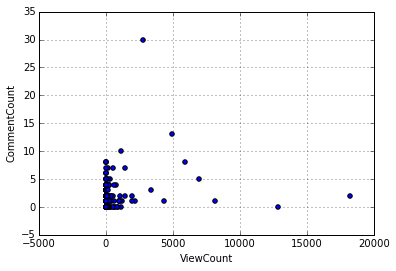

In [15]:
posts_df_pd[['CommentCount', 'ViewCount']].plot(kind='scatter', x='ViewCount', y='CommentCount')

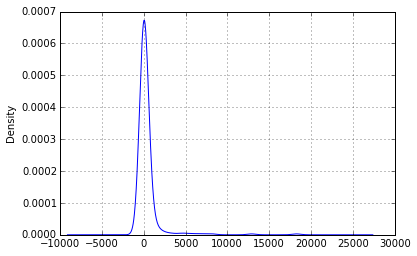

In [14]:
posts_df_pd['ViewCount'].plot(kind='density')

In [19]:
users = xml_to_rdd(data_folder + 'Users.xml')
users.take(1)

[{u'AboutMe': u'<p>Hi, I\'m not really a person.</p>\n\n<p>I\'m a background process that helps keep this site clean!</p>\n\n<p>I do things like</p>\n\n<ul>\n<li>Randomly poke old unanswered questions every hour so they get some attention</li>\n<li>Own community questions and answers so nobody gets unnecessary reputation from them</li>\n<li>Own downvotes on spam/evil posts that get permanently deleted</li>\n<li>Own suggested edits from anonymous users</li>\n<li><a href="http://meta.stackexchange.com/a/92006">Remove abandoned questions</a></li>\n</ul>',
  u'AccountId': -1,
  u'CreationDate': datetime.datetime(2011, 6, 21, 15, 16, 44, 253000),
  u'DisplayName': u'Community',
  u'DownVotes': 2292,
  u'Id': -1,
  u'LastAccessDate': datetime.datetime(2011, 6, 21, 15, 16, 44, 253000),
  u'Location': u'on the server farm',
  u'Reputation': 1,
  u'UpVotes': 24,
  u'Views': 0,
  u'WebsiteUrl': u'http://meta.stackexchange.com/'}]

In [20]:
users_df = rdd_to_df(users,
                     ['Id', 'Reputation', 'DisplayName', 'Age', 'Views', 'UpVotes', 'DownVotes', 'Location'],
                     sql_context)
users_df.show()

Age  DisplayName      DownVotes Id Location             Reputation UpVotes Views
null Community        2292      -1 on the server farm   1          24      0    
37   Geoff Dalgas     0         2  Corvallis, OR        101        1       25   
29   Nick Craver      0         3  Winston-Salem, NC    101        1       10   
28   Emmett           0         4  San Francisco, CA    101        1       6    
null Kevin Montrose   0         5  New York City, Ne... 101        0       4    
27   Jimmy Sawczuk    0         6  Columbia, SC         101        0       3    
29   Seanland         0         8  Ontario, Canada      768        79      15   
27   silent1mezzo     7         9  Toronto, Canada      1808       121     29   
29   Darren Kopp      0         10 Layton, UT           906        43      31   
null user27478        19        11 null                 3607       128     86   
33   daybreaker       0         12 Kenner, LA           406        11      6    
27   Matthew Read     24    

In [21]:
joined = posts_df.filter(posts_df.PostTypeId == 1).join(users_df, posts_df.OwnerUserId == users_df.Id, 'inner')
joined_df_pd = joined.select(
    'Score',
    'Reputation',
    'Age',
    'UpVotes',
    'DownVotes',
    'ViewCount',
    'CommentCount').sample(False, 0.1).dropna().toPandas()

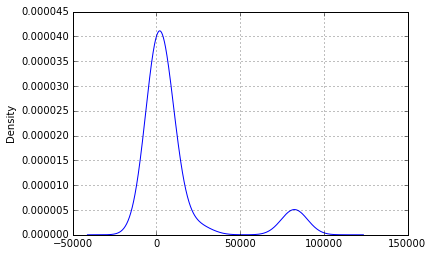

In [22]:
joined_df_pd['Reputation'].plot(kind='density')

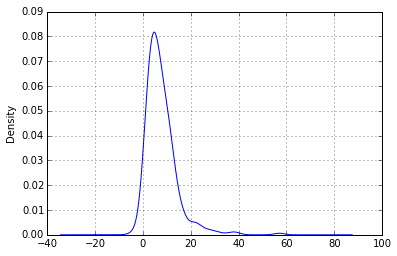

In [23]:
joined_df_pd['Score'].plot(kind='density')

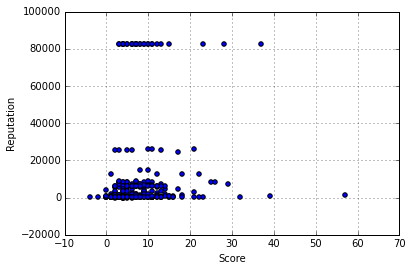

In [24]:
joined_df_pd.plot(kind='scatter', x='Score', y='Reputation')